In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import sys
import importlib
import pandas as pd
from matplotlib.colors import ListedColormap
import matplotlib.gridspec as gridspec

# personal imports
from utils_orbs.orb_paths import SetupPaths
import utils_orbs.readsubfHDF5Py3 as readSub
# from utils.read_group_cats import ReadCats
from utils_orbs.merger_trees import TraceMergerTree
from utils_orbs.readMergerHistoryFiles import FindHistory
from utils_orbs.vectorCorrection import vectorCorrection as vector

paths = SetupPaths()

imported h5py...
modules seem to have loaded?


In [2]:
plt.show();
plt.rcParams.update({'font.size':20,"xtick.direction":"in","ytick.direction":"in", 
                     "xtick.top":True, "ytick.right":True,"text.usetex":False,
                     "xtick.labelsize":18,"ytick.labelsize":18,
                     "xtick.minor.top":True, "ytick.minor.right":True,
                     "xtick.minor.visible": True,
                     "ytick.minor.visible": True})

In [3]:
def make_colorarray(color_val, f):
    """
    creates the correctly scaled array of values from 0,1 for one rgb val
    ---
    inputs: 
    - color_val: float
        float representing one of the r, g, or b values of desired custom colormap
    - f: float
        the location of custom color in colorbar (from 0-1)  
        f = 1, color scale will be from white to rgb
        f = 0, color scale will be from rgb to black
        f = 0.5 - 1, color scale slowly transitions from white to color, then quickly from color to black
        f = 0 - 0.5, color scale quickly transition from white to color, then slowly from color to black
        recommend 0.25 for sparse data with low vals, or 0.75 for sparse at higher vals
    --- 
    returns: 
    - array of length 256, containing linearly spaced values from 0-f and f-1
    ---
    Note: if f*N is not an integer, it will be rounded down to the nearest int
    """
    
    N = 256
    f_val = int(N * f)
    
    white_to_color = np.linspace(1, color_val, f_val)
    color_to_black = np.linspace(color_val, 0, N-f_val)
    
    combined = np.concatenate((white_to_color, color_to_black))
    return combined

def make_colormap(rgb_list, where_color):
    """ 
    creates colormap with alpha = 0
    ---
    inputs: 
    - rgb_list: list or array
                contains 3 elements for the r, g, and b color vals respectively
    - where_color: float in [0,1]
                the location of the colorbar where the color is placed
                if where_color = 1, color scale will be from white to rgb
                if where_color = 0, color scale will be from rgb to black
                if where_color = f, color scale will go from white to rgb at 
                the fraction f of the total colorbar size, then rgb to black
    --- 
    returns:
    - ListedColormap 
    """
        # add below later when you have time
        #     if where_color
    
        #     else: 
        #         raise TypeError("arg 'where_color' should be a float from 0-1")
    
    N = 256 # rgb 
    vals = np.ones((N, 4))
    
    # replace the r, b, and g columns with rgb-specific arrays
    for i in range(3):
        vals[:, i] = make_colorarray(rgb_list[i], where_color)
        
    try: 
        map_object = ListedColormap(vals)
    except NameError:
        err_string = "You have not imported the required matplotlib module.\n\
                      Please add 'from matplotlib.colors import ListedColormap'"
        print(err_string)
    
    return map_object


# Import data

In [4]:
low = {}
f = h5py.File(f"{paths.path_data}hail-mary/unique_orbits.hdf5",'r')
for key, val in f.items():
    low[key] = np.array(val)
f.close()

high = {}
f = h5py.File(f"{paths.path_data}big-bad/unique_orbits_massive.hdf5",'r')
for key, val in f.items():
    high[key] = np.array(val)
f.close()

f = h5py.File(f"{paths.path_data}snapshot_data.hdf5",'r')
convert = {}
for key, val in f.items():
    convert[key] = np.array(val)
f.close()

In [5]:
for i in range(100):
    print(convert['Redshift'][i],convert['Lookback Time'][i])

20.046490988807516 13.623404302747057
14.989173240042412 13.53193460582793
11.980213315300293 13.432545608319812
10.975643294137885 13.385023928036233
9.996590466186333 13.328047666094987
9.388771271940549 13.285813521779149
9.00233985416247 13.255592686360727
8.449476294368743 13.206921996967393
8.012172948865935 13.163077903593194
7.5951071498715965 13.116014413400329
7.23627606616736 13.07071102807556
7.005417045544533 13.038864805705263
6.491597745667503 12.959082346042756
6.0107573988449 12.870999398213229
5.846613747881867 12.837369801676353
5.5297658079491026 12.76644380945972
5.227580973127337 12.690336551052848
4.995933468164624 12.625471426657995
4.664517702470927 12.521067326428017
4.428033736605549 12.436783615191525
4.176834914726472 12.33668348451083
4.0079451114652676 12.262327929201929
3.7087742646422353 12.11422115559416
3.4908613692606485 11.990816433533404
3.2830330579565246 11.858548903738102
3.008131071630377 11.657335574310283
2.8957850057274284 11.5649915522323
2

In [13]:
non_low = low['MergeSnapshot'] == -1 
non_high = high['MergeSnapshot'] == -1 
num_low = np.count_nonzero(non_low)
num_high = np.count_nonzero(non_high)

num_low_tot = len(low['MergeSnapshot'])

In [12]:
print("The number of low-mass non-mergers is ",num_low)
print("The number of high-mass non-mergers is ",num_high)


The number of low-mass non-mergers is  3700
The number of high-mass non-mergers is  903


In [17]:
print(f"The percentage of low-mass non-mergers is {100*num_low/len(non_low):.2f}")
print(f"The percentage of high-mass non-mergers is {100*num_high/len(non_high):.2f}")


The percentage of low-mass non-mergers is 16.66
The percentage of high-mass non-mergers is 29.71


In [29]:
for data, name in [[low,"low"],[high,"high"]]:
    # non-mergers
    non_merger_mask = data["MergeSnapshot"] == -1
    num_non_merger = np.count_nonzero(non_merger_mask)
    num_tot = len(data['MergeSnapshot'])
    print(f"The number of {name}-mass non-mergers is {num_non_merger}")
    print(f"The percentage of {name}-mass pairs that don't merge {100*num_non_merger/num_tot:.2f}%")

    # late infall
    late_infall = data['InfallSnapshot'] > 50
    num_late = np.count_nonzero(late_infall)
    print(f"The number of {name} pairs that infall after z=1 is: {num_late}")
    
    # both
    both_mask = non_merger_mask&late_infall
    both_num = np.count_nonzero(both_mask)
    print(f"The number of {name} pairs that don't merge AND infall after z=1 is: {both_num}")
    print(f"The percent of all {name} pairs that don't merge AND infall after z=1 is: {100*both_num/num_tot:0.2f}%")
    print(f"The percent of late infall {name} pairs that don't merge AND infall after z=1 is: {100*both_num/num_late:0.2f}%")
    
    print(" ")
    print(" ")


The number of low-mass non-mergers is 3700
The percentage of low-mass pairs that don't merge 16.66%
The number of low pairs that infall after z=1 is: 4271
The number of low pairs that don't merge AND infall after z=1 is: 2336
The percent of all low pairs that don't merge AND infall after z=1 is: 10.52%
The percent of late infall low pairs that don't merge AND infall after z=1 is: 54.69%
 
 
The number of high-mass non-mergers is 903
The percentage of high-mass pairs that don't merge 29.71%
The number of high pairs that infall after z=1 is: 1183
The number of high pairs that don't merge AND infall after z=1 is: 778
The percent of all high pairs that don't merge AND infall after z=1 is: 25.60%
The percent of late infall high pairs that don't merge AND infall after z=1 is: 65.77%
 
 


In [43]:
low.keys()

dict_keys(['GroupFlag', 'GroupNum', 'GroupRvir', 'Header', 'InfallRedshift', 'InfallSnapshot', 'MergeFlag', 'MergeRedshift', 'MergeSnapshot', 'PairKey', 'RelativeVelocity', 'Separations', 'SeparationsComoving', 'SeparationsScaled', 'Snapshot', 'StellarMass1', 'StellarMass2', 'StellarMassRatio', 'SubfindID1', 'SubfindID2', 'SubhaloMass1', 'SubhaloMass2', 'SubhaloPos1', 'SubhaloPos2', 'SubhaloVel1', 'SubhaloVel2'])

In [86]:
# non mergers at all redshifts
mean_dat = {}
for data, name in [[low,"low"],[high,"high"]]:
    # non-mergers
    non_merger_mask = data["MergeSnapshot"] == -1
    
    mean_dat[name] = {}
    
    for datum in ['Separations','SeparationsScaled',"RelativeVelocity"]:
        save_xx = []
        
        for i in convert['Snapshot']:
            
            # late infall
            late_infall = data['InfallSnapshot'] <= 33 # after z=2 infall
            after_snap_infall = data['InfallSnapshot'] <= i # after z=2 infall
    
            xx_at_snap = data[datum][:,i]
            xx_masked = xx_at_snap[non_merger_mask&late_infall&after_snap_infall]
            save_xx.append(np.nanmedian(xx_masked))

        mean_dat[name][datum] = save_xx 

/home/u13/katiechambe/.conda/envs/tart/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [81]:
convert['Redshift'][33]

2.0020281392528516

In [72]:
where = (high['InfallSnapshot'][high["MergeSnapshot"] == -1] < 60)

note that the earliest infall snap for a high-mass non-merger is 20 i.e. 4.17

(0.0, 5.0)

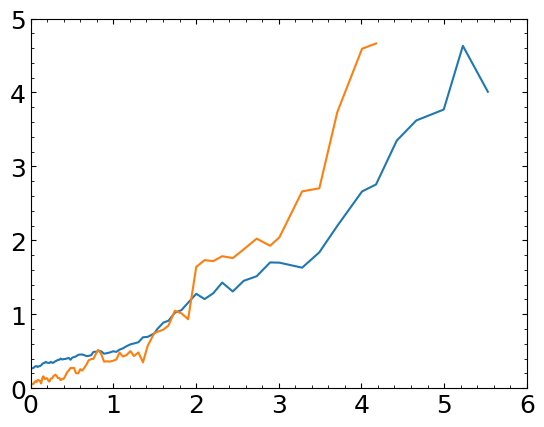

In [88]:
reds = convert['Redshift']


plt.plot(reds, mean_dat['low']['SeparationsScaled'])
plt.plot(reds, mean_dat['high']['SeparationsScaled'])
plt.xlim(0,6)
plt.ylim(0,5)

In [ ]:
mean_seps = {}
for data, name in [[low,"low"],[high,"high"]]:
    # non-mergers
    non_merger_mask = data["MergeSnapshot"] == -1
    num_non_merger = np.count_nonzero(non_merger_mask)
    num_tot = len(data['MergeSnapshot'])
  
    # late infall
    late_infall = data['InfallSnapshot'] > 50
    num_late = np.count_nonzero(late_infall)
  
    # both
    both_mask = non_merger_mask&late_infall
    both_num = np.count_nonzero(both_mask)
    
    mean_seps[name] = {}
    
    for datum in ['Separations','SeparationsScaled',"RelativeVelocity"]:
        save_xx = []
        for i in convert['Snapshot'][50:]:
            xx_at_snap = data[datum][:,i]
#             xx_masked = xx_at_snap[both_mask]
            xx_masked = xx_at_snap[non_merger_mask]
            save_xx.append(np.nanmedian(xx_masked))

        mean_seps[name][datum] = save_xx 

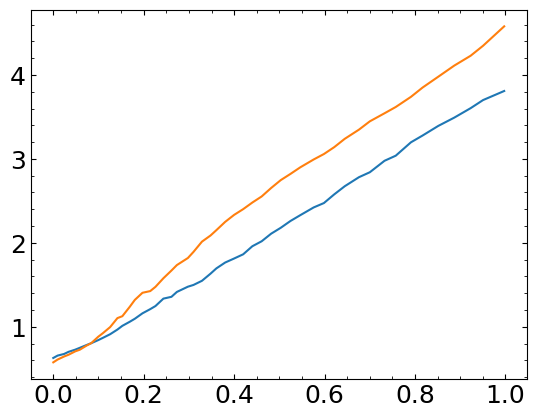

In [56]:
reds = convert['Redshift'][50:]


plt.plot(reds, mean_seps['low']['SeparationsScaled'])
plt.plot(reds, mean_seps['high']['SeparationsScaled'])

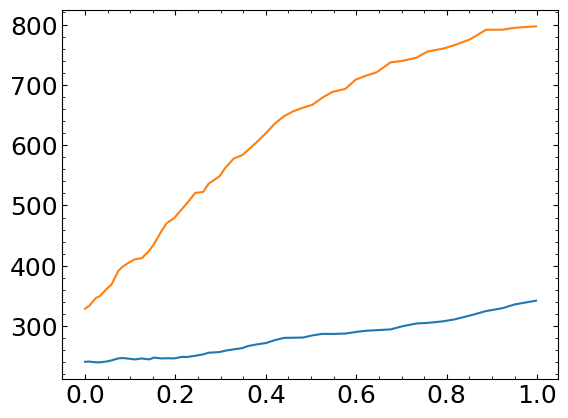

In [53]:
reds = convert['Redshift'][50:]


plt.plot(reds, mean_seps['low']['Separations'])
plt.plot(reds, mean_seps['high']['Separations'])

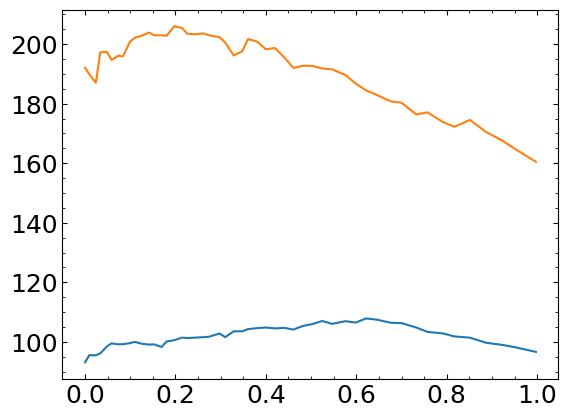

In [40]:
reds = convert['Redshift'][50:]


plt.plot(reds, mean_seps['low']['Vels'])
plt.plot(reds, mean_seps['high']['Vels'])

In [36]:
mean_seps['low']['Vels']

[971.640277349852,
 961.2683215582214,
 954.4589510416542,
 945.1870655544035,
 934.0203265963453,
 922.6301669254213,
 915.0470996945239,
 901.229100977877,
 892.6195372919187,
 878.635144484759,
 868.3342096520935,
 854.6115767360384,
 843.0577917539223,
 830.8794105628962,
 819.4778370490349,
 804.5131657957683,
 791.5605643918329,
 778.1389789947671,
 765.2199302383729,
 751.9093216074924,
 738.0833311753568,
 725.0943838439129,
 709.6138174022434,
 694.579006488213,
 680.6845181677841,
 671.2651488380004,
 657.6397535593869,
 644.4409474662349,
 635.4225223824777,
 617.2477548886754,
 607.2461000629751,
 593.3201186360759,
 579.3139750031189,
 571.0035793435621,
 558.1996565784467,
 545.4428283994093,
 537.5786761885128,
 526.4988293471034,
 519.4240722796173,
 510.07814115909326,
 502.18552111530005,
 497.6098341821027,
 492.3362266304959,
 488.7897042102336,
 483.76818517517796,
 480.0374728489084,
 475.6842765573098,
 473.30720638218685,
 467.5623355046084,
 464.958978639527]

In [23]:
# filter out all of the orbits that don't infall after z=1 (only look at "recent infalls")
late_infall = high['InfallSnapshot'] > 50
np.count_nonzero(late_infall&non_high)


778

In [ ]:
postinfall_willmerge = postinfall_at_snap&merge_later # merging pairs 
seps_will_merge = np.where(postinfall_willmerge, seps_at_snap, np.nan)

mask_lower10 = (seps_will_merge > 10)

seps_for_hist = seps_will_merge[mask_lower10]
number_seps = len(seps_for_hist)

mergesnap = data['MergeSnapshot'][mask_lower10]
mergetimes = convert["Lookback Time"][mergesnap]
mt_for_hist = lbt_at_snap - mergetimes

kwargs = {"range":[[0,300],[0,8]],
          "bins": [int(15),int(16)],
          "cmap":cmap,
          "weights":100*np.ones(number_seps)/number_seps,
          "vmin":0,
          "vmax":vmax
         }

h,_,_,im0 = ax.hist2d(seps_for_hist, mt_for_hist,**kwargs)

return h, im0, number_seps